<a href="https://colab.research.google.com/github/swingdancer777/Credit-Card-Default-Analysis-Project/blob/main/Credit_Card_Default_Data_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
### Performing data cleaning, data analysis, and data visualization on a credit card default dataset

# Dataset

This dataset holds information on credit card user demographic attributes, credit data, history of payment, bill statements, and default payments, of credit card clients in Taiwan from April 2005 to September 2005.

# Variables
There are 25 variables:

 ID: ID of each client
 
 LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
 
 SEX: Gender (1=male, 2=female)
 
 EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
 
 MARRIAGE: Marital status (1=married, 2=single, 3=others)
 
 AGE: Age in years
 
 PAY_0: Repayment status in September, 2005 (-1=pay on time, 1=payment delay for one month, 2=payment delay for two months, ... 
 8=payment delay for eight months, 9=payment delay for nine months and above)
 
 PAY_2: Repayment status in August, 2005 (scale same as above)
 
 PAY_3: Repayment status in July, 2005 (scale same as above)
 
 PAY_4: Repayment status in June, 2005 (scale same as above)
 
 PAY_5: Repayment status in May, 2005 (scale same as above)
 
 PAY_6: Repayment status in April, 2005 (scale same as above)
 
 BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
 
 BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
 
 BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
 
 BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
 
 BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
 
 BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
 
 PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
 
 PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
 
 PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
 
 PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
 
 PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
 
 PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
 
 default.payment.next.month: Default payment (1=yes, 0=no)

# Load libraries

In [ ]:
!pip install catboost
!pip install lightgbm

In [6]:
import pandas as pd # for data processing, CSV file input/output (eg, pd.read_csv) 
import numpy as np  # for linear algebra 
import matplotlib   # for graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc  # garbage collection for memory mgmt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier  # converts categorical values into numbers
import lightgbm as lgb # This is a gradient boosting method that uses tree-based learning algorithms
import xgboost as xgb  # Extreme Gradient Boosting that is a decision-tree-based ensemble ML algorithm

pd.set_option('display.max_columns', 100)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/Credit Card Dataset/UCI_Credit_Card.csv'

Mounted at /content/gdrive


In [8]:
RFC_METRIC = 'gini'  # metric used for the Random Forest Classifier
NUM_ESTIMATORS = 100 # number of estimators used for the random forest
NO_JOBS = 4          # number of random forest jobs to run in parallel

# VALIDATION SAMPLE
VALID_SIZE = 0.20  # hold back 20% of the sample for testing

# CROSS-VALIDATION
NUMBER_KFOLDS = 5 # number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000    # number of Light Gradient Boost rounds
EARLY_STOP = 50      # stop early after 50 LGB rounds
OPT_ROUNDS = 1000    # Adjust after finding the optimal number of validation rounds
VERBOSE_EVAL = 50    # Print out the metric result


#Read the data

In [9]:
# Read the CSV data into a dataframe
credit_df = pd.read_csv(root_path)

# Examine the data

In [10]:
# Determine the number of rows and columns in the dataset
print("UCI Credit Card Default data - rows:", credit_df.shape[0], " columns:", credit_df.shape[1])

UCI Credit Card Default data - rows: 30000  columns: 25


In [11]:
# Look at the first few row of data to get a sense of the data
credit_df.head(7)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0


In [12]:
# Look at summary statistics for the dataset
# Rounded to two decimals here to be easier to read
# round(credit_df.describe(),2)  # alternate syntax
credit_df.describe().round(2)  

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,15000.50,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,-0.29,51223.33,49179.08,47013.15,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50,0.22
std,8660.40,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,1.15,73635.86,71173.77,69349.39,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47,0.42
min,1.00,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-165580.00,-69777.00,-157264.00,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7500.75,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,3558.75,2984.75,2666.25,2326.75,1763.00,1256.00,1000.00,833.00,390.00,296.00,252.50,117.75,0.00
50%,15000.50,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,22381.50,21200.00,20088.50,19052.00,18104.50,17071.00,2100.00,2009.00,1800.00,1500.00,1500.00,1500.00,0.00
75%,22500.25,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,0.00,0.00,67091.00,64006.25,60164.75,54506.00,50190.50,49198.25,5006.00,5000.00,4505.00,4013.25,4031.50,4000.00,0.00
max,30000.00,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,8.00,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00,1.00


In [13]:
# The New Taiwan Dollar to US Dollar exchange rate in April 2005 was around 31:1.
# Show the data in terms of USD for context.
# Drop columns and rows that should not be divided by the exchange rate (ie, ID, sex, education, marriage, age, count).
exchg_rate = 31
USD_credit_df = credit_df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3','PAY_4', 'PAY_5', 'PAY_6','default.payment.next.month'], axis=1)
summary_USD_credit_df = USD_credit_df.describe()
summary_USD_credit_df2 = summary_USD_credit_df.drop(['count'], axis=0)
(summary_USD_credit_df2/exchg_rate).round(2)

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
mean,5402.72,1652.37,1586.42,1516.55,1395.58,1300.37,1253.93,182.70,191.01,168.57,155.68,154.82,168.24
std,4185.41,2375.35,2295.93,2237.08,2075.25,1961.20,1921.10,534.30,743.25,567.97,505.36,492.85,573.47
min,322.58,-5341.29,-2250.87,-5073.03,-5483.87,-2623.68,-10954.94,0.00,0.00,0.00,0.00,0.00,0.00
25%,1612.90,114.80,96.28,86.01,75.06,56.87,40.52,32.26,26.87,12.58,9.55,8.15,3.80
50%,4516.13,721.98,683.87,648.02,614.58,584.02,550.68,67.74,64.81,58.06,48.39,48.39,48.39
75%,7741.94,2164.23,2064.72,1940.80,1758.26,1619.05,1587.04,161.48,161.29,145.32,129.46,130.05,129.03
max,32258.06,31113.26,31739.71,53680.29,28760.84,29908.74,31021.42,28179.10,54330.94,28904.52,20032.26,13759.00,17053.74


#Describe the data in words

These data are of credit card users in Taiwan from April 2005 - Sept 2005.
The New Taiwan Dollar (NTD) to US Dollar (USD) exchange rate was about 31 NTD to 1 USD in April 2005.

There are 30,000 credit lines.

The average credit limit is USD 5402 / NTD 167,484.

The average credit card bill amount ranged from USD 1254 to 1652 / NTD 38,871 to 51,223.

The average payment amount ranged from USD 154 to 191 / NTD 4799 to 5921.

Most of the users have a university or graduate level education.

Most of the users are married or single.

The average age is 35.5 years, and the middle 50% of the population ranges from 21 years to 41 years old.

For "default payment", "0" means "no default" and "1" means "default". The average is 0.22, which indicates that 22% of credit card users will default in the next month. This will be verified in this examination.


### Check for missing data 

Use the original dataset in New Taiwan Dollars to check

In [15]:
total_values = credit_df.isnull().sum().sort_values(ascending = False)
percent_of_total = (credit_df.isnull().sum()/credit_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total_values, percent_of_total], axis=1, keys=['Total_Value', 'Percent_of_Total']).transpose()

,default.payment.next.month,PAY_6,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,BILL_AMT1,PAY_AMT6,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,ID
Total_Value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent_of_Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the credit payment data set.

### Check for imbalanced data

**default.payment.next.month** is the target result, so we will check for imbalanced data in this value.

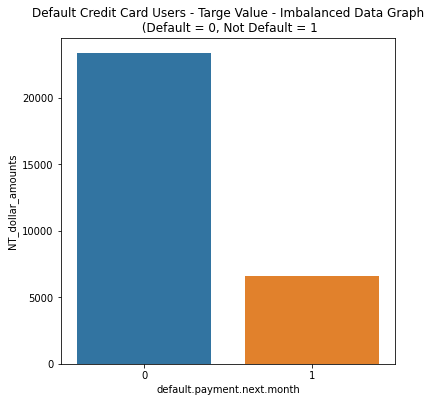

In [16]:
# count the number of "next month default payments" that are defaults and that are not
temp_df = credit_df['default.payment.next.month'].value_counts() 
df1 = pd.DataFrame({'default.payment.next.month': temp_df.index, 'NT_dollar_amounts': temp_df.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Users - Targe Value - Imbalanced Data Graph\n (Default = 0, Not Default = 1')
sns.set_color_codes('deep')
sns.barplot(x = 'default.payment.next.month', y = 'NT_dollar_amounts', data = df1)
locs, labels = plt.xticks()
plt.show()

In [17]:
expected_default_pct = credit_df['default.payment.next.month'].mean()
print("Expected/average percentage of defaults next month:", expected_default_pct)
print("Expected/average number of defaults next month:", expected_default_pct*30000)

Expected/average percentage of defaults next month: 0.2212
Expected/average number of defaults next month: 6636.0


Out of 30,000 credit card users, 6636 (which is 22.12%) are expected to default next month.
This number seems sufficiently large compared to the total, so the 'default.payment.next.month' value is not significantly imbalanced.

# Exploratory Data Analysis

### Credit limit amount


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


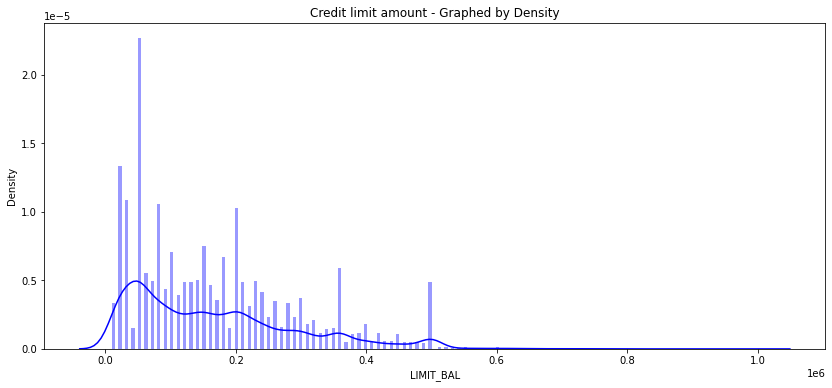

In [18]:
plt.figure(figsize = (14,6))
plt.title('Credit limit amount - Graphed by Density')
sns.set_color_codes("deep")
sns.distplot(credit_df['LIMIT_BAL'], kde=True, bins=200, color="blue")  #kde = True means to plot the gaussian kernl density estimate
plt.show()

The credit limit that has been granted the most to users is NTD 50,000. This will be verified.

In [19]:
credit_df['LIMIT_BAL'].value_counts().shape

(81,)

The "credit limit" variable has 81 unique values.

In [20]:
credit_df['LIMIT_BAL'].value_counts().head(7)

50000.0     3365
20000.0     1976
30000.0     1610
80000.0     1567
200000.0    1528
150000.0    1110
100000.0    1048
Name: LIMIT_BAL, dtype: int64

The largest number of credit cards (3365) has a limit of NTD 50,000.

The second largest number of credit cards (1976) has a limit of NTD 20,000.

The third largest number of credit cards (1610) has a limit of NTD 30,000.

# Credit limit amounts grouped by default payment next month

Now we visualize the density plot for amount of credit limit (LIMIT_BAL), grouped by default payment next month.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


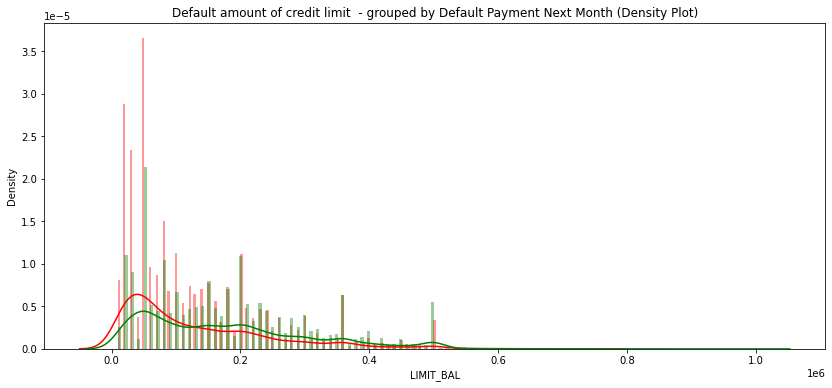

In [22]:
class_0 = credit_df.loc[credit_df['default.payment.next.month'] == 0]["LIMIT_BAL"]
class_1 = credit_df.loc[credit_df['default.payment.next.month'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit  - grouped by Default Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

In the density graph above, accounts that default are graphed in red. Accounts that do not are graphed in green. We see that most defaults happen to credit limits up to NTD 100,000 ("0.1" on the graph). We also see that the density for defaulting accounts is higher than for non-defaulting accounts. Finally, the credit limits of NTD 20,000, NTD 30,000, and NTD 50,000 are also high (shown by large red lines).